In [97]:
import numpy as np
import pandas as pd
import h5py
import torch
import os
import matplotlib.pyplot as plt
import seaborn as sns

#from utils import *

In [2]:
NUM_PLOTTED_CONDITIONS = 6
NUM_PLOTTED_CONDITIONS_WITH_GLOBAL = 10
NUM_CLIENTS = 14
NUM_FOLDS = 5

In [3]:
def load_final_model_performances(cv_results_path, filename, type=None, num_clients=14, num_folds=7, verbose=False):
    extraction_dict = dict()
    for i in range(num_folds):
        h5_path = os.path.join(cv_results_path, filename+f"{i}.h5")
        #print(h5_path)
        
        # Load data from HDF5 file
        with h5py.File(h5_path, 'r') as f:
            #print(f.keys())
            a_group_key = list(f.keys())
            for key in a_group_key:
                #print(key)
        
                if key=="client_local_test_log":
                    client_keys = list(f[key])
                    #print(client_keys)
                    for ck in client_keys:
                        ed_key = f"{ck}_fold{i}"  # Does this never update from or something...
                        #print(f"Key: {key}, Client: {ck}, Fold: {i}")
    
                        # So this doenst have any knoledge of the fold number???
                        if len(list(f[key][ck]))==0:
                            #print(f"{ed_key} SKIPPED!")
                            pass
                        else:
                            #print(f"{ed_key} SUCCESS!")
                            extraction_dict[ed_key] = list(f[key][ck])
                elif key=="global_test_error_log" and "NOFL" not in filename:
                    # Do I need to turn this off for NoFL? Or will it just be empty and append something empty...
                    ed_key = f"{key}_fold{i}"
                    #print(ed_key)
                    extraction_dict[ed_key] = list(f[key])
                elif key=="local_test_error_log":
                    # Genuinely have no idea what this is... is it client_local_test_log but already averaged out?? No clue
                    ed_key = f"{key}_fold{i}"
                    #print(ed_key)
                    extraction_dict[ed_key] = list(f[key])
                else:
                    pass
            #print()

    # So now that all that is extracted and saved to the dict, iterate through the dict and... average by client?
    client_logs = {f'S{i}_client_local_test_log': [] for i in range(num_clients)}  # S0 to S13
    global_test_log = []
    local_test_log = []
    for fold in range(num_folds):
        for i in range(num_clients):
            # Access client local test logs for each fold
            client_key = f'S{i}_client_local_test_log_fold{fold}'
            try:
                client_data = np.array(extraction_dict[client_key])
                #print(f"{client_key}: {client_data.shape}") --> It doesnt get to here if it fails!
    
                if len(client_logs[f'S{i}_client_local_test_log']) == 0:
                    client_logs[f'S{i}_client_local_test_log'] = client_data
                else:
                    client_logs[f'S{i}_client_local_test_log'] += client_data
                    
                #print(f"{client_key} SUCCESS!")
            except KeyError:
                # It was a testing client and thus not saved, so just skip to the next iter
                #print(f"{client_key} FAILED!")
                pass

        #print(filename)
        if "NOFL" in filename:
            pass
        else: 
            # Access global and local test logs for each fold
            global_key = f'global_test_error_log_fold{fold}'
            #print(extraction_dict.keys())
            global_data = extraction_dict[global_key][:]
            if len(global_test_log) == 0:
                global_test_log = np.array(global_data)
            else:
                global_test_log += np.array(global_data)
        
        local_key = f'local_test_error_log_fold{fold}'
        local_data = extraction_dict[local_key][:]
        if len(local_test_log) == 0:
            local_test_log = np.array(local_data)
        else:
            local_test_log += np.array(local_data)
    
    # Average the client test logs and the global/local test errors
    ## In the cross scenario, it should divide client_logs by 6, not 7, since each client is withheld once
    averaged_client_logs = {client: np.array(client_logs[client]) / num_folds for client in client_logs}
    if "NOFL" in filename:
        averaged_global_test_log = None
    else:    
        averaged_global_test_log = np.array(global_test_log) / num_folds
    averaged_local_test_log = np.array(local_test_log) / num_folds
    
    # Return the results
    return averaged_client_logs, averaged_global_test_log, averaged_local_test_log


# Sims Results Plot

In [4]:
results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\FinalSimRes'
base_path = results_path + current_directory

'''
# CROSS
10-05_14-23_NOFL_Cross
10-05_14-32_PFAFO_Cross5
10-05_14-48_FEDAVG_Cross5
10-05_15-08_FEDAVG_Cross1
10-05_15-14_PFAFO_Cross1

# INTRA
10-05_13-44_NOFL_Intra
10-05_13-46_FEDAVG_Intra5
10-05_13-55_FEDAVG_Intra1
10-05_14-10_PFAFO_Intra1
10-05_14-13_PFAFO_Intra5
'''

# CROSS
cpfa_avg_cli_logs, cpfa_avg_glo_tst_log, cpfa_avg_loc_tst_log = load_final_model_performances(base_path+r'\10-05_14-32_PFAFO_Cross5', 'GDLS_PFAFO_KFold', type="CROSS")
cfa_avg_cli_logs, cfa_avg_glo_tst_log, cfa_avg_loc_tst_log = load_final_model_performances(base_path+r'\10-05_14-48_FEDAVG_Cross5', 'GDLS_FEDAVG_KFold', type="CROSS")
cnofl_avg_cli_logs, _, cnofl_avg_loc_tst_log = load_final_model_performances(base_path+r'\10-05_14-23_NOFL_Cross', 'FULLSCIPYMIN_NOFL_KFold', type="CROSS")
# INTRA
ipfa_avg_cli_logs, ipfa_avg_glo_tst_log, ipfa_avg_loc_tst_log = load_final_model_performances(base_path+r'\10-05_14-13_PFAFO_Intra5', 'GDLS_PFAFO_KFold', type="INTRA")
ifa_avg_cli_logs, ifa_avg_glo_tst_log, ifa_avg_loc_tst_log = load_final_model_performances(base_path+r'\10-05_13-46_FEDAVG_Intra5', 'GDLS_FEDAVG_KFold', type="INTRA")
inofl_avg_cli_logs, _, inofl_avg_loc_tst_log = load_final_model_performances(base_path+r'\10-05_13-44_NOFL_Intra', 'FULLSCIPYMIN_NOFL_KFold', type="INTRA")


In [5]:
keys = list(cpfa_avg_cli_logs.keys())
keys

['S0_client_local_test_log',
 'S1_client_local_test_log',
 'S2_client_local_test_log',
 'S3_client_local_test_log',
 'S4_client_local_test_log',
 'S5_client_local_test_log',
 'S6_client_local_test_log',
 'S7_client_local_test_log',
 'S8_client_local_test_log',
 'S9_client_local_test_log',
 'S10_client_local_test_log',
 'S11_client_local_test_log',
 'S12_client_local_test_log',
 'S13_client_local_test_log']

In [6]:
cpfa_avg_cli_dict = {i: value for i, value in enumerate(cpfa_avg_cli_logs.values())}
cfa_avg_cli_dict = {i: value for i, value in enumerate(cfa_avg_cli_logs.values())}
cnofl_avg_cli_dict = {i: value for i, value in enumerate(cnofl_avg_cli_logs.values())}
ipfa_avg_cli_dict = {i: value for i, value in enumerate(ipfa_avg_cli_logs.values())}
ifa_avg_cli_dict = {i: value for i, value in enumerate(ifa_avg_cli_logs.values())}
inofl_avg_cli_dict = {i: value for i, value in enumerate(inofl_avg_cli_logs.values())}


In [7]:
def mean_of_last_n(values, n=10):
    return np.mean(values[-n:])

# Create lists by calculating the mean of the last 10 values
cpfa_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in cpfa_avg_cli_logs.values()]
cfa_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in cfa_avg_cli_logs.values()]
cnofl_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in cnofl_avg_cli_logs.values()]
ipfa_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in ipfa_avg_cli_logs.values()]
ifa_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in ifa_avg_cli_logs.values()]
inofl_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in inofl_avg_cli_logs.values()]


In [8]:
inofl_avg_cli_lst

[1.2776575664559067e-06,
 1.0105792618169173e-06,
 8.582097260579316e-07,
 1.4739363493955515e-06,
 1.1500988490327914e-06,
 7.813016971179134e-07,
 7.738445220691144e-07,
 1.119351118931838e-06,
 4.7059166122801727e-07,
 1.0677695713907473e-06,
 9.89121133954513e-07,
 1.0245945389856636e-06,
 4.2974958909049063e-07,
 4.983168919424254e-07]

In [9]:
#cli_fold_log_lst = 
INTRA_cli_fold_log_lst = [inofl_avg_cli_dict, ifa_avg_cli_dict, ipfa_avg_cli_dict]
CROSS_cli_fold_log_lst = [cnofl_avg_cli_dict, cfa_avg_cli_dict, cpfa_avg_cli_dict]

INTRA_finalavg_cli_fold_log_lst = [inofl_avg_cli_lst, ifa_avg_cli_lst, ipfa_avg_cli_lst]
CROSS_finalavg_cli_fold_log_lst = [cnofl_avg_cli_lst, cfa_avg_cli_lst, cpfa_avg_cli_lst]

all_trials_lst = [inofl_avg_cli_lst, ifa_avg_cli_lst, ipfa_avg_cli_lst, cnofl_avg_cli_lst, cfa_avg_cli_lst, cpfa_avg_cli_lst]

In [10]:

# Define the scenario and algorithm information
scenarios = ['Intra-Subject'] * 3 + ['Cross-Subject'] * 3
algorithms = ['LocalBatchMin', 'FedAvg', 'Per-FedAvg', 'LocalBatchMin', 'FedAvg', 'Per-FedAvg']

# Create an empty list to store rows
rows = []

# Loop over each trial result, scenario, and algorithm to create rows
for i, trial_results in enumerate(all_trials_lst):
    for client_idx, result in enumerate(trial_results):
        rows.append([scenarios[i], algorithms[i], client_idx + 1, result])

# Convert to a DataFrame
df = pd.DataFrame(rows, columns=['Scenario', 'Algorithm', 'Client', 'Test Loss'])

print(df.shape)
df.head()

(84, 4)


,Scenario,Algorithm,Client,Test Loss
0,Intra-Subject,LocalBatchMin,1,1.277658e-06
1,Intra-Subject,LocalBatchMin,2,1.010579e-06
2,Intra-Subject,LocalBatchMin,3,8.582097e-07
3,Intra-Subject,LocalBatchMin,4,1.473936e-06
4,Intra-Subject,LocalBatchMin,5,1.150099e-06


In [11]:
# Save the DataFrame to a CSV file
#df.to_csv('sim__results_condition_losses.csv', index=False)

In [12]:

# Create an empty list to store rows
rows = []

# Loop over each trial result, scenario, and algorithm to create rows
for i, trial_results in enumerate(all_trials_lst):
    row = [scenarios[i], algorithms[i]] + trial_results
    rows.append(row)

# Create DataFrame with columns for each client
columns = ['Scenario', 'Algorithm'] + [f'Test Loss Client_{j+1}' for j in range(len(all_trials_lst[0]))]
df = pd.DataFrame(rows, columns=columns)

print(df.shape)
df.head()

(6, 16)


,Scenario,Algorithm,Test Loss Client_1,Test Loss Client_2,Test Loss Client_3,Test Loss Client_4,Test Loss Client_5,Test Loss Client_6,Test Loss Client_7,Test Loss Client_8,Test Loss Client_9,Test Loss Client_10,Test Loss Client_11,Test Loss Client_12,Test Loss Client_13,Test Loss Client_14
0,Intra-Subject,LocalBatchMin,1.277658e-06,1.010579e-06,8.582097e-07,1.473936e-06,1.150099e-06,7.813017e-07,7.738445e-07,1.119351e-06,4.705917e-07,1.067770e-06,9.891211e-07,1.024595e-06,4.297496e-07,4.983169e-07
1,Intra-Subject,FedAvg,2.099321e-07,2.097514e-07,1.962876e-07,2.073569e-07,2.056376e-07,2.084448e-07,1.977096e-07,1.700018e-07,1.746748e-07,1.711814e-07,1.756953e-07,1.720394e-07,1.754470e-07,1.770753e-07
2,Intra-Subject,Per-FedAvg,2.062377e-07,2.071192e-07,1.980129e-07,2.072254e-07,2.053047e-07,2.082156e-07,1.985883e-07,1.718933e-07,1.747856e-07,1.736425e-07,1.743739e-07,1.741356e-07,1.767734e-07,1.771520e-07
3,Cross-Subject,LocalBatchMin,4.074979e-03,5.164923e-03,4.716512e-03,4.174560e-03,4.964350e-03,4.921355e-03,5.980499e-03,7.084225e-03,6.612236e-03,4.799999e-03,4.813089e-03,3.569071e-03,6.851207e-03,8.111559e-03
4,Cross-Subject,FedAvg,1.358696e-03,1.351354e-03,1.358346e-03,1.349561e-03,1.351753e-03,1.347144e-03,1.384212e-03,1.374950e-03,1.395079e-03,1.384159e-03,1.401616e-03,1.390523e-03,1.383862e-03,1.378956e-03


In [13]:
#cpfa_final_global_loss = mean_of_last_n(cpfa_avg_glo_tst_log)
#cfa_final_global_loss = mean_of_last_n(cfa_avg_glo_tst_log)
#ipfa_final_global_loss = mean_of_last_n(ipfa_avg_glo_tst_log)
#ifa_final_global_loss = mean_of_last_n(ifa_avg_glo_tst_log)

> In intra: global model is evaluated but on many separate test sets... so there should be a per client global loss...

            - Is what I have for intra global loss rn just the averaged loss across each clients local test set? Not sure... but presumably...

> In cross: global model is evaulated on a single aggregated test set, so there is only a single loss vector

> Global models:

In [14]:
cpfa_final_global_loss = mean_of_last_n(cpfa_avg_glo_tst_log)
cfa_final_global_loss = mean_of_last_n(cfa_avg_glo_tst_log)
ipfa_final_global_loss = mean_of_last_n(ipfa_avg_glo_tst_log)
ifa_final_global_loss = mean_of_last_n(ifa_avg_glo_tst_log)


In [15]:
print(f"cpfa_final_global_loss: {cpfa_final_global_loss}")
print(f"cfa_final_global_loss: {cfa_final_global_loss}")
print(f"ipfa_final_global_loss: {ipfa_final_global_loss}")
print(f"ifa_final_global_loss: {ifa_final_global_loss}")

cpfa_final_global_loss: 0.001591974585117313
cfa_final_global_loss: 0.001591795695679914
ipfa_final_global_loss: 1.8872805098211622e-07
ifa_final_global_loss: 1.8861044875185247e-07


## Performance: Final Avg Test Loss

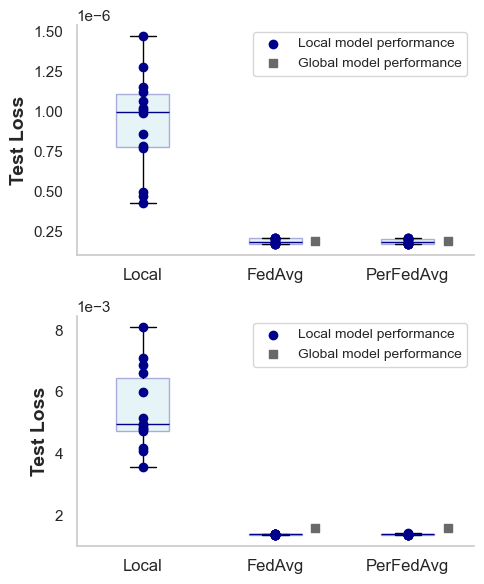

In [16]:
# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Set up the figure and two subplots (without shared x-axis)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

# Define x-tick labels
x_labels_intra = ['Local', 'FedAvg', 'PerFedAvg']
x_labels_cross = ['Local', 'FedAvg', 'PerFedAvg']

# Positions for the local and global data points
positions_intra = np.arange(len(x_labels_intra))
positions_cross = np.arange(len(x_labels_cross))

# BOX PLOTS
box_width = 0.4  # Reduce the box plot width
# Intra-subject (first subplot)
all_trials_intra = all_trials_lst[:3]
boxplot_elements1 = ax1.boxplot(all_trials_intra, positions=positions_intra, widths=box_width, patch_artist=True, zorder=0)
# Cross-subject (second subplot)
all_trials_cross = all_trials_lst[3:]
boxplot_elements2 = ax2.boxplot(all_trials_cross, positions=positions_cross, widths=box_width, patch_artist=True, zorder=0)

# Colors and adjustments
light_blue = 'lightblue'
dark_blue = 'darkblue'
light_grey = 'lightgrey'
dark_grey = 'dimgrey'
offset = 0.3
global_model_marker = 's'  # square marker for global model

# Customize boxplot colors (set somewhat transparent boxes)
for box in boxplot_elements1['boxes'] + boxplot_elements2['boxes']:
    box.set_facecolor(light_blue)
    box.set_edgecolor(dark_blue)
    box.set_alpha(0.3)  # Adjust transparency to see scatter points more clearly

# Set median color to a darker shade of blue
for median in boxplot_elements1['medians'] + boxplot_elements2['medians']:
    median.set_color(dark_blue)

# Scatter plots for local points (full opacity, no alpha)
for i in range(len(all_trials_lst)):
    if i < 3:  # Intra-subject case (first subplot)
        ax1.scatter([i] * len(all_trials_lst[i]), all_trials_lst[i], color=dark_blue, zorder=1, label='Local model performance')
    else:  # Cross-subject case (second subplot)
        ax2.scatter([i - 3] * len(all_trials_lst[i]), all_trials_lst[i], color=dark_blue, zorder=1, label='Local model performance')

# Scatter plots for global model points (light grey, offset on x-axis, full opacity)
global_model_data = [ifa_final_global_loss, ipfa_final_global_loss, cfa_final_global_loss, cpfa_final_global_loss]

for i, global_loss in enumerate(global_model_data[:2]):
    ax1.scatter([i+1 + offset], global_loss, color=dark_grey, zorder=2, marker=global_model_marker, label='Global model performance')

for i, global_loss in enumerate(global_model_data[2:], start=3):
    ax2.scatter([i+1 - 3 + offset], global_loss, color=dark_grey, zorder=2, marker=global_model_marker, label='Global model performance')

# Set consistent font sizes for both plots
for ax in [ax1, ax2]:
    ax.set_ylabel("Test Loss", fontsize=14, weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Set x-tick labels individually for each plot
ax1.set_xticks(positions_intra)
ax1.set_xticklabels(x_labels_intra, fontsize=12)

ax2.set_xticks(positions_cross)
ax2.set_xticklabels(x_labels_cross, fontsize=12)
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

# After plotting points and boxplots in ax1 and ax2
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
unique_ax1 = dict(zip(labels_ax1, handles_ax1))  # Removes duplicates
#
handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()
unique_ax2 = dict(zip(labels_ax2, handles_ax2))  # Removes duplicates
#
# Set legends with unique labels for both subplots
ax1.legend(unique_ax1.values(), unique_ax1.keys(), loc='upper right', fontsize=10)
ax2.legend(unique_ax2.values(), unique_ax2.keys(), loc='upper right', fontsize=10)

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()

# Save and show the figure
plt.savefig('SimsResults_OffsetGlobal.jpg', dpi=500)
plt.show()


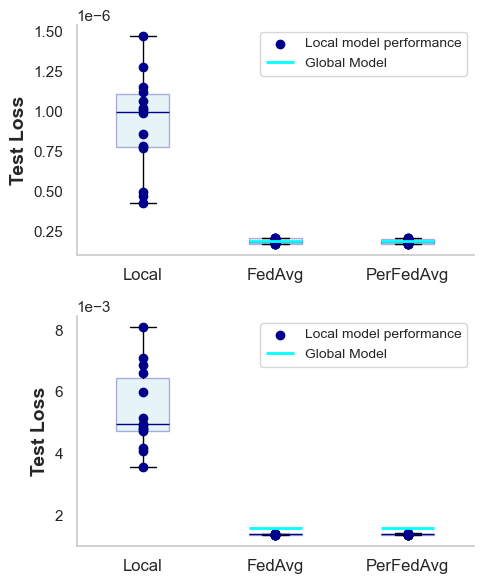

In [17]:
# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Set up the figure and two subplots (without shared x-axis)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

# Define x-tick labels
x_labels_intra = ['Local', 'FedAvg', 'PerFedAvg']
x_labels_cross = ['Local', 'FedAvg', 'PerFedAvg']

# Positions for the local and global data points
positions_intra = np.arange(len(x_labels_intra))
positions_cross = np.arange(len(x_labels_cross))

# BOX PLOTS
box_width = 0.4  # Reduce the box plot width
# Intra-subject (first subplot)
all_trials_intra = all_trials_lst[:3]
boxplot_elements1 = ax1.boxplot(all_trials_intra, positions=positions_intra, widths=box_width, patch_artist=True, zorder=0)
# Cross-subject (second subplot)
all_trials_cross = all_trials_lst[3:]
boxplot_elements2 = ax2.boxplot(all_trials_cross, positions=positions_cross, widths=box_width, patch_artist=True, zorder=0)

# Colors and adjustments
light_blue = 'lightblue'
dark_blue = 'darkblue'
light_grey = 'lightgrey'
dark_grey = 'dimgrey'
cyan = 'cyan'  # cyan color for global model line

# Customize boxplot colors (set somewhat transparent boxes)
for box in boxplot_elements1['boxes'] + boxplot_elements2['boxes']:
    box.set_facecolor(light_blue)
    box.set_edgecolor(dark_blue)
    box.set_alpha(0.3)  # Adjust transparency to see scatter points more clearly

# Set median color to a darker shade of blue
for median in boxplot_elements1['medians'] + boxplot_elements2['medians']:
    median.set_color(dark_blue)

# Scatter plots for local points (full opacity, no alpha)
for i in range(len(all_trials_lst)):
    if i < 3:  # Intra-subject case (first subplot)
        ax1.scatter([i] * len(all_trials_lst[i]), all_trials_lst[i], color=dark_blue, zorder=1, label='Local model performance')
    else:  # Cross-subject case (second subplot)
        ax2.scatter([i - 3] * len(all_trials_lst[i]), all_trials_lst[i], color=dark_blue, zorder=1, label='Local model performance')

# Global model data for cyan line on box plots
global_model_data = [ifa_final_global_loss, ipfa_final_global_loss, cfa_final_global_loss, cpfa_final_global_loss]

# Plot cyan lines for global model performance on the box plots (same as median line)
# For intra-subject (ax1)
global_positions = [1, 2]
for i, global_loss in enumerate(global_model_data[:2]):
    ax1.hlines(global_loss, global_positions[i] - box_width / 2, global_positions[i] + box_width / 2, color=cyan, linewidth=2, label='Global Model', zorder=2)
# For cross-subject (ax2)
for i, global_loss in enumerate(global_model_data[2:], start=0):
    ax2.hlines(global_loss, global_positions[i] - box_width / 2, global_positions[i] + box_width / 2, color=cyan, linewidth=2, label='Global Model', zorder=2)

# Set consistent font sizes for both plots
for ax in [ax1, ax2]:
    ax.set_ylabel("Test Loss", fontsize=14, weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Set x-tick labels individually for each plot
ax1.set_xticks(positions_intra)
ax1.set_xticklabels(x_labels_intra, fontsize=12)

ax2.set_xticks(positions_cross)
ax2.set_xticklabels(x_labels_cross, fontsize=12)
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

# After plotting points and boxplots in ax1 and ax2
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
unique_ax1 = dict(zip(labels_ax1, handles_ax1))  # Removes duplicates
#
handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()
unique_ax2 = dict(zip(labels_ax2, handles_ax2))  # Removes duplicates
#
# Set legends with unique labels for both subplots
ax1.legend(unique_ax1.values(), unique_ax1.keys(), loc='upper right', fontsize=10)
ax2.legend(unique_ax2.values(), unique_ax2.keys(), loc='upper right', fontsize=10)

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()

# Save and show the figure
plt.savefig('SimsResults_CyanGlobal.jpg', dpi=500)
plt.show()


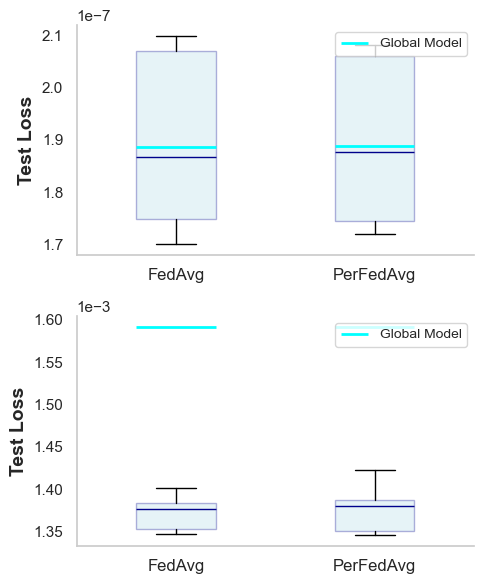

In [18]:

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Set up the figure and two subplots (without shared x-axis)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

# Define x-tick labels (only FedAvg and PerFedAvg)
x_labels_intra = ['FedAvg', 'PerFedAvg']
x_labels_cross = ['FedAvg', 'PerFedAvg']

# Positions for the intra and cross-subject data points (adjusted to skip "Local")
positions_intra = np.arange(len(x_labels_intra))
positions_cross = np.arange(len(x_labels_cross))

# BOX PLOTS
box_width = 0.4  # Reduce the box plot width

# Intra-subject (first subplot) - only using FedAvg and PerFedAvg
all_trials_intra = all_trials_lst[1:3]  # Skip index 0 (Local)
boxplot_elements1 = ax1.boxplot(all_trials_intra, positions=positions_intra, widths=box_width, patch_artist=True, zorder=0)

# Cross-subject (second subplot) - only using FedAvg and PerFedAvg
all_trials_cross = all_trials_lst[4:6]  # Skip index 3 (Local)
boxplot_elements2 = ax2.boxplot(all_trials_cross, positions=positions_cross, widths=box_width, patch_artist=True, zorder=0)

# Colors and adjustments
light_blue = 'lightblue'
dark_blue = 'darkblue'
cyan = 'cyan'  # cyan color for global model line

# Customize boxplot colors (set somewhat transparent boxes)
for box in boxplot_elements1['boxes'] + boxplot_elements2['boxes']:
    box.set_facecolor(light_blue)
    box.set_edgecolor(dark_blue)
    box.set_alpha(0.3)  # Adjust transparency to see scatter points more clearly

# Set median color to a darker shade of blue
for median in boxplot_elements1['medians'] + boxplot_elements2['medians']:
    median.set_color(dark_blue)

# Global model data for cyan line on box plots (FedAvg and PerFedAvg only)
global_model_data = [ifa_final_global_loss, ipfa_final_global_loss, cfa_final_global_loss, cpfa_final_global_loss]

# Plot cyan lines for global model performance on the box plots
# For intra-subject (ax1)
global_positions = [0, 1]  # Adjusted to match FedAvg and PerFedAvg positions
for i, global_loss in enumerate(global_model_data[:2]):
    ax1.hlines(global_loss, global_positions[i] - box_width / 2, global_positions[i] + box_width / 2, color=cyan, linewidth=2, label='Global Model', zorder=2)

# For cross-subject (ax2)
for i, global_loss in enumerate(global_model_data[2:], start=0):
    ax2.hlines(global_loss, global_positions[i] - box_width / 2, global_positions[i] + box_width / 2, color=cyan, linewidth=2, label='Global Model', zorder=2)

# Set consistent font sizes for both plots
for ax in [ax1, ax2]:
    ax.set_ylabel("Test Loss", fontsize=14, weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Set x-tick labels individually for each plot
ax1.set_xticks(positions_intra)
ax1.set_xticklabels(x_labels_intra, fontsize=12)

ax2.set_xticks(positions_cross)
ax2.set_xticklabels(x_labels_cross, fontsize=12)
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

# After plotting points and boxplots in ax1 and ax2
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
unique_ax1 = dict(zip(labels_ax1, handles_ax1))  # Removes duplicates

handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()
unique_ax2 = dict(zip(labels_ax2, handles_ax2))  # Removes duplicates

# Set legends with unique labels for both subplots
ax1.legend(unique_ax1.values(), unique_ax1.keys(), loc='upper right', fontsize=10)
ax2.legend(unique_ax2.values(), unique_ax2.keys(), loc='upper right', fontsize=10)

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()

# Save and show the figure
#plt.savefig('SimsResults_CyanGlobal_FL_ONLY.jpg', dpi=500)
plt.show()


# Final Avg Tracking Performance Error

In [19]:
## UW Figure Code (plotting actual trajectories)

if False:
    # Calculate the average time-domain error across all subjects

    time_x = times_block1[k][c]
    td_error = np.empty((2, len(keys), len(conds), min_time)) # len(update_ix)-2 so we can avoid the last interval
    
    # get the time-domain error average across batches
    for iK, key in enumerate(keys):
        for iC, cond in enumerate(conds):
            # BLOCK 1
            b = 0
            ref = refs_block1[key][iC] # ref = time x 2
            pos = poss_block1[key][iC] # pos = time x 2
            td_error[b, iK, iC, :] = calc_time_domain_error(ref, pos)
            
            # BLOCK 2
            b = 1
            ref = refs_block2[key][iC] # ref = time x 2
            pos = poss_block2[key][iC] # pos = time x 2
            td_error[b, iK, iC, :] = calc_time_domain_error(ref, pos)
            
    # first 20 seconds after ramp 
    t0_start = RAMP 
    t0_end = int(tscale*25)-1 # so that both times are the same 
    print("first 20 seconds after ramp, starting at index: ", t0_start, "ending at index: ", t0_end)
    
    # take the average of the first 20 seconds across subjects, blocks and conditions
    td_error_first = np.mean(td_error[:, :, :, t0_start:t0_end], axis = -1) # 2 x 7 x 8
    assert(td_error_first.shape == (2, len(keys), len(conds)))
    
    # last 20 seconds
    t1_end = int(tscale*20)
    print("last 20 seconds, starting at index: ", t1_end)
    
    # make sure that the time lengths are the same
    assert((t0_end - t0_start) == t1_end)
    
    # take average of the last 20 seconds, across subjects blocks and conditions
    td_error_last = np.mean(td_error[:, :, :, -t1_end:], axis=-1) # -t1_end takes the last 20 seconds index
    assert(td_error_last.shape == (2, len(keys), len(conds)))
    
    # BLOCK 1 - without the 5 seconds ramp
    b = 0
    td_b1_25, td_b1_50, td_bl_75 = np.percentile(td_error[b, :, :, t0_start:], [25, 50, 75], axis=(0, 1))
    plt.plot(time_x[t0_start:], td_b1_50)
    plt.fill_between(time_x[t0_start:], td_b1_25, td_bl_75, alpha=0.2)
    
    # BLOCK 2 - without the 5 seconds ramp
    b = 1
    td_b2_25, td_b2_50, td_b2_75 = np.percentile(td_error[b, :, :, t0_start:], [25, 50, 75], axis=(0, 1))
    plt.plot(time_x[t0_start:], td_b2_50)
    plt.fill_between(time_x[t0_start:], td_b2_25, td_b2_75, alpha=0.2)
    
    plt.title("Comparing time-domain error without the ramp")
    plt.xlabel("time (seconds)")
    plt.ylabel("$||t - y||_2$")
    plt.box(False)

In [45]:
def load_cfc_logs(cv_results_path, filename, type=None, num_clients=14, num_folds=7, verbose=False):
    extraction_dict = dict()
    for i in range(num_folds):
        h5_path = os.path.join(cv_results_path, filename+f"{i}.h5")
        #print(h5_path)
        
        # Load data from HDF5 file
        with h5py.File(h5_path, 'r') as f:
            #print(f.keys())
            a_group_key = list(f.keys())
            for key in a_group_key:
                #print(key)
        
                if key=="client_global_cost_func_comps_log" or key=="client_local_cost_func_comps_log":
                    client_keys = list(f[key])
                    #print("key {key}; client keys:")
                    #print(client_keys)
                    for ck in client_keys:
                        ed_key = f"{ck}_fold{i}"  # Does this never update from or something...
                        #print(f"Key: {key}, Client: {ck}, Fold: {i}")
        
                        # So this doenst have any knoledge of the fold number???
                        if len(list(f[key][ck]))==0:
                            val = list(f[key][ck])
                            #print(f"{ed_key} SKIPPED!")
                            pass
                        else:
                            #print(f"{ed_key} SUCCESS!")
                            extraction_dict[ed_key] = list(f[key][ck])
                else:
                    pass
    return extraction_dict


In [46]:
NUM_PLOTTED_CONDITIONS = 6
NUM_PLOTTED_CONDITIONS_WITH_GLOBAL = 10
NUM_CLIENTS = 14
NUM_FOLDS = 5

results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\FinalSimRes'
base_path = results_path + current_directory

'''
# CROSS
10-05_14-23_NOFL_Cross
10-05_14-32_PFAFO_Cross5
10-05_14-48_FEDAVG_Cross5
10-05_15-08_FEDAVG_Cross1
10-05_15-14_PFAFO_Cross1

# INTRA
10-05_13-44_NOFL_Intra
10-05_13-46_FEDAVG_Intra5
10-05_13-55_FEDAVG_Intra1
10-05_14-10_PFAFO_Intra1
10-05_14-13_PFAFO_Intra5
'''

# CROSS
cpfa_cfc_dict = load_cfc_logs(base_path+r'\10-05_14-32_PFAFO_Cross5', 'GDLS_PFAFO_KFold')
cfa_cfc_dict = load_cfc_logs(base_path+r'\10-05_14-48_FEDAVG_Cross5', 'GDLS_FEDAVG_KFold')
cnofl_cfc_dict = load_cfc_logs(base_path+r'\10-05_14-23_NOFL_Cross', 'FULLSCIPYMIN_NOFL_KFold')
# INTRA
ipfa_cfc_dict = load_cfc_logs(base_path+r'\10-05_14-13_PFAFO_Intra5', 'GDLS_PFAFO_KFold')
ifa_cfc_dict = load_cfc_logs(base_path+r'\10-05_13-46_FEDAVG_Intra5', 'GDLS_FEDAVG_KFold')
inofl_cfc_dict = load_cfc_logs(base_path+r'\10-05_13-44_NOFL_Intra', 'FULLSCIPYMIN_NOFL_KFold')


In [144]:
def avg_client_results_across_folds(extraction_dict, algorithm, num_clients=14, num_folds=7, verbose=False):
    print(f"ALGO: {algorithm}")
    client_logs = {f'S{i}_client_local_cost_func_comps_log': 0.0 for i in range(num_clients)}  # S0 to S13
    global_logs = {f'S{i}_client_global_cost_func_comps_log': 0.0 for i in range(num_clients)}  # S0 to S13
    for fold in range(num_folds):
        for i in range(num_clients):
            # Access client local test logs for each fold
            client_key = f'S{i}_client_local_cost_func_comps_log_fold{fold}'
            try:
                client_last_n_logs = np.array(extraction_dict[client_key][-10:]) 
                client_data = np.mean([ele[1] for ele in client_last_n_logs])
                #print(f"client data shape: {client_data.shape}")
                if client_logs[f'S{i}_client_local_cost_func_comps_log'] == 0.0:
                    #print("Instantiating empty entry")
                    client_logs[f'S{i}_client_local_cost_func_comps_log'] = client_data
                else:
                    #print("Adding new data")
                    client_logs[f'S{i}_client_local_cost_func_comps_log'] += client_data
                #print(f"Local cli{i} SUCCESS!")
            except KeyError:
                # It was a testing client and thus not saved, so just skip to the next iter
                #print(f"Local cli{i} FAILED!")
                pass
    
            if "NOFL" in algorithm:
                pass
            else: 
                # Access global and local test logs for each fold
                global_key = f'S{i}_client_global_cost_func_comps_log_fold{fold}'
                try:
                    client_last_n_global_logs = np.array(extraction_dict[global_key][-10:]) 
                    # Mean across last n values, for one client, within one fold
                    client_global_data = np.mean([ele[1] for ele in client_last_n_global_logs])
                    if global_logs[f'S{i}_client_global_cost_func_comps_log'] == 0.0:
                        global_logs[f'S{i}_client_global_cost_func_comps_log'] = client_global_data
                    else:
                        global_logs[f'S{i}_client_global_cost_func_comps_log'] += client_global_data
                    #print(f"Global cli{i} SUCCESS!")
                except KeyError:
                    # It was a testing client and thus not saved, so just skip to the next iter
                    #print(f"Global cli{i} FAILED!")
                    pass
            #print()
    print()
    
    # Return the results
    return client_logs, global_logs

In [138]:
cpfa_cfc_avg_client_dict, cpfa_cfc_avg_global_logs = avg_client_results_across_folds(cpfa_cfc_dict, "PFA")
cfa_cfc_avg_client_dict, cfa_cfc_avg_global_dict = avg_client_results_across_folds(cfa_cfc_dict, "FedAvg")
cnofl_cfc_avg_client_dict, _ = avg_client_results_across_folds(cnofl_cfc_dict, "NOFL")
ipfa_cfc_avg_client_dict, ipfa_cfc_avg_global_dict = avg_client_results_across_folds(ipfa_cfc_dict, "PFA")
ifa_cfc_avg_client_dict, ifa_cfc_avg_global_dict = avg_client_results_across_folds(ifa_cfc_dict, "FedAvg")
inofl_cfc_avg_client_dict, _ = avg_client_results_across_folds(inofl_cfc_dict, "NOFL")
                                

In [156]:
# ORDER MATTERS!!!
## Making it match the order from the first set of graphs
## Code for labels is hardcoded in the figure! So thats why it must match

all_dicts = [inofl_cfc_avg_client_dict, ifa_cfc_avg_client_dict, ipfa_cfc_avg_client_dict, cnofl_cfc_avg_client_dict, cfa_cfc_avg_client_dict, cpfa_cfc_avg_client_dict]
all_trials_lst = [list(my_dict.values()) for my_dict in all_dicts]

global_dicts = [ifa_cfc_avg_global_dict, ipfa_cfc_avg_global_dict, cpfa_cfc_avg_global_logs, cfa_cfc_avg_global_dict]
global_model_data_by_client = [list(my_dict.values()) for my_dict in global_dicts]
global_model_data = [np.mean(list(my_dict.values())) for my_dict in global_dicts]

In [155]:
global_model_data

[0.0015770331698729111,
 0.0015819923497377537,
 0.009547666433315243,
 0.00954336935984568]

In [157]:
for i in range(4):
    for j in range(4):
        print(f"{i}, {j}: {np.sum(np.array(global_model_data_by_client[i]) - np.array(global_model_data_by_client[j]))}")

0, 0: 0.0
0, 1: -6.942851810778981e-05
0, 2: -0.11158886568819262
0, 3: -0.11152870665961875
1, 0: 6.942851810778981e-05
1, 1: 0.0
1, 2: -0.11151943717008483
1, 3: -0.11145927814151096
2, 0: 0.11158886568819262
2, 1: 0.11151943717008483
2, 2: 0.0
2, 3: 6.01590285738661e-05
3, 0: 0.11152870665961875
3, 1: 0.11145927814151096
3, 2: -6.01590285738661e-05
3, 3: 0.0


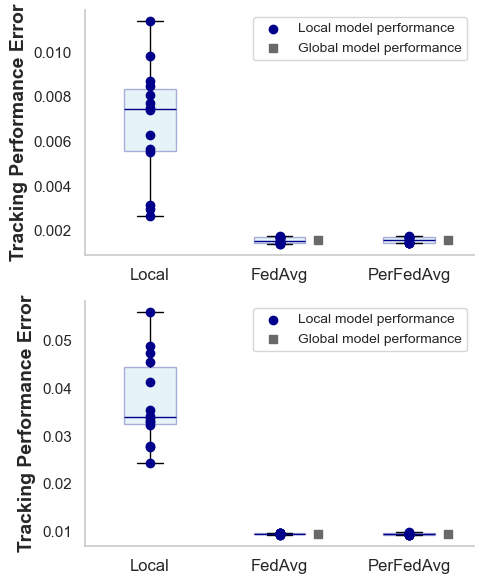

In [161]:
# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Set up the figure and two subplots (without shared x-axis)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

# Define x-tick labels
x_labels_intra = ['Local', 'FedAvg', 'PerFedAvg']
x_labels_cross = ['Local', 'FedAvg', 'PerFedAvg']

# Positions for the local and global data points
positions_intra = np.arange(len(x_labels_intra))
positions_cross = np.arange(len(x_labels_cross))

# BOX PLOTS
box_width = 0.4  # Reduce the box plot width
# Intra-subject (first subplot)
all_trials_intra = all_trials_lst[:3]
boxplot_elements1 = ax1.boxplot(all_trials_intra, positions=positions_intra, widths=box_width, patch_artist=True, zorder=0)
# Cross-subject (second subplot)
all_trials_cross = all_trials_lst[3:]
boxplot_elements2 = ax2.boxplot(all_trials_cross, positions=positions_cross, widths=box_width, patch_artist=True, zorder=0)

# Colors and adjustments
light_blue = 'lightblue'
dark_blue = 'darkblue'
light_grey = 'lightgrey'
dark_grey = 'dimgrey'
offset = 0.3
global_model_marker = 's'  # square marker for global model

# Customize boxplot colors (set somewhat transparent boxes)
for box in boxplot_elements1['boxes'] + boxplot_elements2['boxes']:
    box.set_facecolor(light_blue)
    box.set_edgecolor(dark_blue)
    box.set_alpha(0.3)  # Adjust transparency to see scatter points more clearly

# Set median color to a darker shade of blue
for median in boxplot_elements1['medians'] + boxplot_elements2['medians']:
    median.set_color(dark_blue)

# Scatter plots for local points (full opacity, no alpha)
for i in range(len(all_trials_lst)):
    if i < 3:  # Intra-subject case (first subplot)
        ax1.scatter([i] * len(all_trials_lst[i]), all_trials_lst[i], color=dark_blue, zorder=1, label='Local model performance')
    else:  # Cross-subject case (second subplot)
        ax2.scatter([i - 3] * len(all_trials_lst[i]), all_trials_lst[i], color=dark_blue, zorder=1, label='Local model performance')

# Scatter plots for global model points (light grey, offset on x-axis, full opacity)
for i, global_loss in enumerate(global_model_data[:2]):
    ax1.scatter([i+1 + offset], global_loss, color=dark_grey, zorder=2, marker=global_model_marker, label='Global model performance')
for i, global_loss in enumerate(global_model_data[2:], start=3):
    ax2.scatter([i+1 - 3 + offset], global_loss, color=dark_grey, zorder=2, marker=global_model_marker, label='Global model performance')

# Set consistent font sizes for both plots
for ax in [ax1, ax2]:
    ax.set_ylabel("Tracking Performance Error", fontsize=14, weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Set x-tick labels individually for each plot
ax1.set_xticks(positions_intra)
ax1.set_xticklabels(x_labels_intra, fontsize=12)

ax2.set_xticks(positions_cross)
ax2.set_xticklabels(x_labels_cross, fontsize=12)
#ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

# After plotting points and boxplots in ax1 and ax2
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
unique_ax1 = dict(zip(labels_ax1, handles_ax1))  # Removes duplicates
#
handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()
unique_ax2 = dict(zip(labels_ax2, handles_ax2))  # Removes duplicates
#
# Set legends with unique labels for both subplots
ax1.legend(unique_ax1.values(), unique_ax1.keys(), loc='upper right', fontsize=10)
ax2.legend(unique_ax2.values(), unique_ax2.keys(), loc='upper right', fontsize=10)

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()

# Save and show the figure
##plt.savefig('SimsResults_OffsetGlobal.jpg', dpi=500)
plt.show()
